In [1]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [3]:
llm.invoke("hi")

AIMessage(content='Hello! 👋\n\nHow can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 5.1e-07, 'queue_time': 0.01936417, 'total_time': 0.027273237}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-e7d4e6f9-a4f6-445d-9d19-350e5d3012fa-0', usage_metadata={'input_tokens': 10, 'output_tokens': 15, 'total_tokens': 25})

In [4]:
llm.invoke("hi").content

'Hello! 👋  How can I help you today?\n'

In [5]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [6]:

multiply({"first_number":24,"second_number":364})

C:\Users\lenovo\AppData\Local\Temp\ipykernel_11784\4272159846.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [7]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [8]:

@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [9]:
search("who is a current president of USA?")

[{'url': 'https://www.usa.gov/presidents',
  'content': 'Vice president of the United States\nThe vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform his or her duties. President of the United States\nThe president of the United States is the:\nCurrent president\nThe 46th and current president of the United States is Joseph R. Biden, Jr. First lady\nThe First lady of the United States has traditionally been the wife or other close female relative of the president of the United States. Requirements to be eligible to become president\nAccording to Article II of the U.S. Constitution, the president must:\nLearn about the U.S. presidential election process.\n If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n'},
 {'url': 'https://en.wikipedia.org/wiki/List_of_Presidents_of_the_United_

In [10]:
tools=[search,multiply]

In [11]:
model_with_tools = llm.bind_tools(tools)

In [13]:
model_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C698E14E10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C698B40190>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'perform the web search on the user query', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'multiply two integer number', 'parameters': {'properties': {'first_number': {'type': 'integer'}, 'second_number': {'type': 'integer'}}, 'required': ['first_number', 'second_number'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [12]:
tool_mapping={tool.name: tool for tool in tools}

In [14]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C698E0E0C0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001C698E0F380>)}

In [15]:
response = model_with_tools.invoke("who is a current president of USA?")

In [16]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8f65', 'function': {'arguments': '{"query":"who is the current president of the USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1076, 'total_tokens': 1163, 'completion_time': 0.158181818, 'prompt_time': 0.062931642, 'queue_time': 0.021389191000000002, 'total_time': 0.22111346}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bf9b0081-a980-4492-b159-f3604e6a75af-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of the USA'}, 'id': 'call_8f65', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 87, 'total_tokens': 1163})

In [17]:
tool_details=response.additional_kwargs.get("tool_calls")

In [18]:
tool_details

[{'id': 'call_8f65',
  'function': {'arguments': '{"query":"who is the current president of the USA"}',
   'name': 'search'},
  'type': 'function'}]

In [19]:
tool_details[0]["function"]["name"]

'search'

In [20]:
tool_details[0]["function"]["arguments"]

'{"query":"who is the current president of the USA"}'

In [21]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'who is the current president of the USA'}

In [22]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'url': 'https://simple.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'The president is also the head of the executive branch of the federal government of the United States and is the chairman of the presidential cabinet.[10]\nJoe Biden is the 46th and current president of the United States, in office since January 2021.[11]\nEligibility and requirements[change | change source]\nArticle II, Section 1, Clause 5 of the constitution states for a person to serve as president must:\nElection process and presidential terms[change | change source]\nThe president is elected by the people through the Electoral College to a four-year term, along with the vice presidential candidate or the incumbent vice president of the United States as their running mate.[12] Contents\nPresident of the United States\nThe president of the United States (POTUS)[9] is the head of state and head of government of the United States of America and the commander-in-chief of the United States Armed F

In [23]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [24]:
def invoke_model(state:AgentState): # agent
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]} # response with tools call

In [25]:
def invoke_tool(state:AgentState): # tools call
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    # The function extracts the last message from the state object's messages list.
    # It then retrieves the tool_calls value from the additional_kwargs dictionary of the last message. If tool_calls is not present, it defaults to an empty list.
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]} # response go back to agent

In [26]:

def router(state): # routing function for agent 
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", []) # check if call tools
    if len(tool_calls): # if tool calls
        return "tool" # return tool
    else:
        return "end" # return end

In [27]:

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model) # agent 

graph.add_node("tool", invoke_tool) # tool

In [28]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [29]:

app = graph.compile()

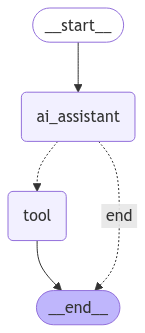

In [30]:
app

In [31]:

for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1gze', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1075, 'total_tokens': 1158, 'completion_time': 0.150909091, 'prompt_time': 0.059144324, 'queue_time': 0.047140187, 'total_time': 0.210053415}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b577ab87-b1a3-45ad-98ce-56caeec46be3-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'call_1gze', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 83, 'total_tokens': 1158})]}
----
Selected tool: search
{'messages': [[{'url': 'https://www.nbcnews.com/politics/2024-election/trump-wins-election-president-harris-defeat-2024-race-rcna176107', 'content': 'Donald Trump defeats Kamala Har

In [32]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j2kh', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1080, 'total_tokens': 1173, 'completion_time': 0.169090909, 'prompt_time': 0.043354499, 'queue_time': 0.020297051000000003, 'total_time': 0.212445408}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6a4cf4c3-7ec8-432e-8df2-5757acc981b6-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_j2kh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 93, 'total_tokens': 1173})]}
----
Selected tool: multiply
{'messages': [1058]}
----


In [34]:

for s in app.stream({"messages": ["what is the total amount of money exist over the earth?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p35s', 'function': {'arguments': '{"query":"What is the total amount of money exist over the earth?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1080, 'total_tokens': 1170, 'completion_time': 0.163636364, 'prompt_time': 0.059288783, 'queue_time': 0.024610147, 'total_time': 0.222925147}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3f16793e-5066-4dfc-bfb8-1ae3b9809e84-0', tool_calls=[{'name': 'search', 'args': {'query': 'What is the total amount of money exist over the earth?'}, 'id': 'call_p35s', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 90, 'total_tokens': 1170})]}
----
Selected tool: search
{'messages': [[{'url': 'https://www.ncesc.com/geographic-faq/how-much-money-has-exists-in-the-world/', 'content': 'How mu

In [35]:

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [36]:

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [37]:
tavily=TavilySearchResults()

In [38]:
tools = [tavily]

In [39]:
llm_with_tools = llm.bind_tools(tools)

In [40]:
def ai_assistant(state: AgentState): # agent
    return {"messages": [llm_with_tools.invoke(state["messages"])]} # call tools

In [41]:

memory = MemorySaver()

In [42]:

graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [43]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [44]:

app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"], # ask yes or no for searh tools calling
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [ ]:

# This code snippet is compiling a graph using the graph_builder.compile method. Here's what's happening:
# Compilation Options
# checkpointer=memory: This option specifies that the graph should use an in-memory checkpointer. This means that the graph's state will be stored in memory, allowing for faster checkpointing and restoration.
# Interruption Points
# interrupt_before=["tools"]: This option specifies that the graph should interrupt execution before reaching the "tools" node. This allows for external intervention or processing before the "tools" node is executed.
# Alternative Interruption Point
# interrupt_after=["tools"]: This is a commented-out option that would interrupt execution after the "tools" node has been executed. This can be useful if you need to perform some processing or intervention after the "tools" node has completed.
# By setting interrupt_before=["tools"], the graph will pause execution before reaching the "tools" node, allowing for external intervention or processing.

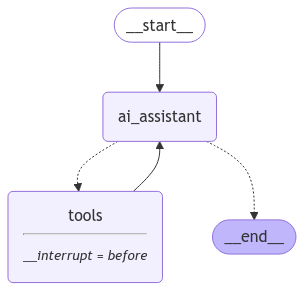

In [45]:
app2

In [83]:

user_input = "what is current capital of india?" # query is capital of india that is generating by tavily search
config = {"configurable": {"thread_id": "1"}}

In [84]:

# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [85]:
events

<generator object Pregel.stream at 0x000001C698CB7870>

In [86]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current capital of india?
================================== Ai Message ==================================

New Delhi


In [50]:
snapshot = app2.get_state(config)

In [51]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='67cb5898-51c1-4543-bbc1-01a35148f406'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ckad', 'function': {'arguments': '{"query":"capital of india"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 989, 'total_tokens': 1076, 'completion_time': 0.158181818, 'prompt_time': 0.039906401, 'queue_time': 0.020924778999999998, 'total_time': 0.198088219}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b7cd0d1-5814-4b4e-80a8-3d9ffd7824d8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of india'}, 'id': 'call_ckad', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 87, 'total_tokens': 1076})]}, next=('to

In [52]:
snapshot.next

('tools',)

In [53]:
last_message=snapshot.values["messages"][-1]

In [82]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_29yt', 'function': {'arguments': '{"query":"weather in new delhi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 2312, 'total_tokens': 2362, 'completion_time': 0.090909091, 'prompt_time': 0.095146698, 'queue_time': 0.022799881999999994, 'total_time': 0.186055789}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9eaee356-69f9-4d9e-ac04-40f397fbd095-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in new delhi'}, 'id': 'call_29yt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2312, 'output_tokens': 50, 'total_tokens': 2362})

In [54]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'capital of india'},
  'id': 'call_ckad',
  'type': 'tool_call'}]

In [55]:

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [56]:
events

<generator object Pregel.stream at 0x000001C698CB6700>

In [57]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ckad)
 Call ID: call_ckad
  Args:
    query: capital of india
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.worldatlas.com/articles/what-is-the-capital-of-india.html", "content": "Related\nThe Largest Empires In The History Of India\nBiggest Ethnic Groups In India\nMore in World Facts\nThe Largest Countries In Asia By Area\n Also, the durbar was held in Delhi so as to welcome the Prince of Wales; hence the British associated Delhi with royal heritage.\n What is the Capital of India?\nIndia, also known as the Republic of India is located in South Asia. For historical reasons, Red Fort which is located in New Delhi is a reminder to the British when they defeated the Mughal ruler in 1857. Initially, the capital city was in Kolkata when King George V of Britain ordered that 

In [58]:

user_input = "what is a weather there?" # of Dehi which is being pull from memory of thread_id 1

config = {"configurable": {"thread_id": "1"}}

In [59]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [60]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_29yt)
 Call ID: call_29yt
  Args:
    query: weather in new delhi


In [61]:

snapshot = app2.get_state(config)

In [62]:

snapshot.next

('tools',)

In [63]:


last_message=snapshot.values["messages"][-1]

In [64]:

last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in new delhi'},
  'id': 'call_29yt',
  'type': 'tool_call'}]

In [65]:

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [66]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_29yt)
 Call ID: call_29yt
  Args:
    query: weather in new delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New Delhi', 'region': 'Delhi', 'country': 'India', 'lat': 28.6, 'lon': 77.2, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1737366844, 'localtime': '2025-01-20 15:24'}, 'current': {'last_updated_epoch': 1737366300, 'last_updated': '2025-01-20 15:15', 'temp_c': 23.4, 'temp_f': 74.1, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 10.1, 'wind_kph': 16.2, 'wind_degree': 306, 'wind_dir': 'NW', 'pressure_mb': 1014.0, 'pressure_in': 29.94, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 50, 'cloud': 0, 'feelslike_c': 24.0, 'feelslike_f': 

In [67]:

app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='67cb5898-51c1-4543-bbc1-01a35148f406'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ckad', 'function': {'arguments': '{"query":"capital of india"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 989, 'total_tokens': 1076, 'completion_time': 0.158181818, 'prompt_time': 0.039906401, 'queue_time': 0.020924778999999998, 'total_time': 0.198088219}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b7cd0d1-5814-4b4e-80a8-3d9ffd7824d8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of india'}, 'id': 'call_ckad', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 87, 'total_tokens': 1076}), ToolMessage

In [68]:

snapshot=app2.get_state(config)

In [69]:

snapshot.next

()

In [87]:

user_input = "give me the gps location  of it?" # of Delhi which is being used from memory

config = {"configurable": {"thread_id": "1"}}

In [88]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [89]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the gps location  of it?
================================== Ai Message ==================================

The GPS coordinates for New Delhi are approximately 28.6139° N, 77.2090° E.


In [90]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [91]:

snapshot=app2.get_state(config)

In [92]:

current_message = snapshot.values["messages"][-1]

In [95]:
current_message

AIMessage(content='The GPS coordinates for New Delhi are approximately 28.6139° N, 77.2090° E. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 4392, 'total_tokens': 4426, 'completion_time': 0.061818182, 'prompt_time': 0.140978558, 'queue_time': 0.04002990100000001, 'total_time': 0.20279674}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-37fa0155-76e8-4f97-bd97-8e65301c78be-0', usage_metadata={'input_tokens': 4392, 'output_tokens': 34, 'total_tokens': 4426})

In [93]:

current_message.pretty_print()

================================== Ai Message ==================================

The GPS coordinates for New Delhi are approximately 28.6139° N, 77.2090° E.


In [94]:

tool_call_id = current_message.tool_calls[0]["id"] 

IndexError: list index out of range

In [78]:

from langchain_core.messages import AIMessage, ToolMessage

In [79]:

answer = "it is just related to raining which is happing on daily basis"

In [80]:

new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

NameError: name 'tool_call_id' is not defined